# Borrowers Credibility Analisys

Bank want to know what factors have influence on it's borrowers payability. To do this we are going to find out if family status or number of children are might be a cause of payments failures. On input we have statistical data about customers credibility. Exploration results will be used in building credit scoring model.


## Data Exploration

In [1]:
#install libraries
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 199 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 24.8 MB 116 kB/s  eta 0:00:01    |█████▉                          | 4.5 MB 26.9 MB/s eta 0:00:01


In [151]:
#libraries importing and data loading
import pandas as pd
from pymystem3 import Mystem
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_auc_score
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
import seaborn as sns


random_state=12345

In [4]:
data = pd.read_csv('/datasets/data.csv')

In [5]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [6]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [7]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


### Conclusion

Missing values in days_employed, total_income columns 

## Data Preprocessing

### Missing Values Handling

In [8]:
#missing values
print('Number of missing values in days_employed column', len(data[data['days_employed'].isna()]))  
print('Number of missing values in total_income column', len(data[data['total_income'].isna()]))  

Number of missing values in days_employed column 2174
Number of missing values in total_income column 2174


In [9]:
# number of items for each income type 
income_types = data['income_type'].value_counts() 
income_types

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

In [10]:
# missing values distribution
for i in income_types.index:
    print(i, data[data['income_type'] == i].isnull().sum().sum())

сотрудник 2210
компаньон 1016
пенсионер 826
госслужащий 294
безработный 0
предприниматель 2
в декрете 0
студент 0


In [11]:
#fill missing values
data['total_income'] = data['total_income'].fillna(data.groupby('income_type')['total_income'].transform('median'))
print('Number of missing values in total_income column', len(data[data['total_income'].isna()])) 

Number of missing values in total_income column 0


In [12]:
#column days_employed contains inadecuacy values, try to fix it
data['days_employed'].describe()

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

In [13]:
data[(data['days_employed'] < 0)]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
...,...,...,...,...,...,...,...,...,...,...,...,...
21519,1,-2351.431934,37,ученая степень,4,в разводе,3,M,сотрудник,0,115949.039788,покупка коммерческой недвижимости
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [14]:
data['days_employed'] = data['days_employed'].apply(lambda x: -1*x if x < 0 else x)

In [15]:
filter_de = data[data['days_employed'] > 15000].index


In [16]:
data = data.drop(filter_de)

In [17]:
data['days_employed'] = data['days_employed'].fillna(data['days_employed'].median()) 

In [18]:
data['days_employed'] = data['days_employed'].astype('int')

In [19]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,18067.000000,18067.000000,18067.000000,18067.000000,18067.000000,18067.000000,1.806700e+04
mean,0.617535,2255.463940,40.262301,0.798694,0.970665,0.086290,1.705929e+05
std,1.435872,2142.922543,10.964971,0.552003,1.439515,0.280799,1.002137e+05
min,-1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,2.136765e+04
25%,0.000000,866.000000,32.000000,0.000000,0.000000,0.000000,1.135420e+05
50%,0.000000,1628.000000,40.000000,1.000000,0.000000,0.000000,1.458765e+05
75%,1.000000,2891.500000,48.000000,1.000000,1.000000,0.000000,1.998598e+05
max,20.000000,14920.000000,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [20]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья


### Conclusion

Amount of missing values in days_employed and total_income is equal. And they palce in the same rows. Therefore, sources of they appearence are common. Number of NaN's for each of incom_type value are almost the same - about 10%. So missing values have filled with median values grouped by incom_type. We picked median to avoid influence of outliers.

### Data Type Converting

In [21]:
# convert to integer to make it more suitable
data['total_income'] = data['total_income'].astype(int)
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18067 entries, 0 to 21524
Data columns (total 12 columns):
children            18067 non-null int64
days_employed       18067 non-null int64
dob_years           18067 non-null int64
education           18067 non-null object
education_id        18067 non-null int64
family_status       18067 non-null object
family_status_id    18067 non-null int64
gender              18067 non-null object
income_type         18067 non-null object
debt                18067 non-null int64
total_income        18067 non-null int64
purpose             18067 non-null object
dtypes: int64(7), object(5)
memory usage: 1.8+ MB


### Duplicates Handling

In [22]:
#convert to lower case and drop duplicates
data['education'] = data['education'].str.lower() # понизим регистр в столбце education для исключчения дубликатов
data.drop_duplicates() # уберем все явные дубликаты, если они есть

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
...,...,...,...,...,...,...,...,...,...,...,...,...
21519,1,2351,37,ученая степень,4,в разводе,3,M,сотрудник,0,115949,покупка коммерческой недвижимости
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля


In [23]:
data['children'].value_counts()

 0     10983
 1      4564
 2      2038
 3       324
 20       69
-1        40
 4        40
 5         9
Name: children, dtype: int64

In [24]:
#fix inadecuacy values
data['children'] = data['children'].replace(-1, 1) 
data.drop(data[data['children'] == 20].index, inplace=True)  

In [25]:
data['dob_years'].min()

0

In [26]:
data.drop(data[data['dob_years'] < 18].index, inplace=True) #удалим всех "несовершеннолетних" заемщиков

In [27]:
#incorrect values XNA
data['gender'].value_counts() 

F      11321
M       6593
XNA        1
Name: gender, dtype: int64

In [28]:
#check synonyms
data['purpose'].value_counts() 

свадьба                                   669
на проведение свадьбы                     643
сыграть свадьбу                           637
операции с недвижимостью                  559
покупка коммерческой недвижимости         554
покупка жилья для сдачи                   548
операции с жильем                         548
операции с коммерческой недвижимостью     538
недвижимость                              538
покупка своего жилья                      538
жилье                                     536
покупка жилья для семьи                   532
операции со своей недвижимостью           532
строительство собственной недвижимости    528
покупка жилья                             527
строительство недвижимости                523
покупка недвижимости                      518
ремонт жилью                              517
покупка жилой недвижимости                515
строительство жилой недвижимости          510
на покупку своего автомобиля              432
заняться высшим образованием      

### Conclusion

### Lemmatization

In [29]:
#перегруппируем все цели получения кредита на категории связанные со свадьбой, автомобилем, образованием, жильем и другой недвижимостью 
m = Mystem()

def lemm_func(row):
    word = m.lemmatize(row['purpose'])
    if 'свадьба' in word:
        return 'свадьба'
    elif 'автомобиль' in word:
        return 'автомобиль'
    elif 'образование' in word:
        return 'образование'
    elif 'жилье' in word:
        return 'жилье'
    else:
        return 'недвижимость'
        
data['lemm_purpose'] = data.apply(lemm_func,axis=1)

In [30]:
# check output
data['lemm_purpose'].value_counts()
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemm_purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,жилье


### Conclusion

Handled similar values via lemmatization

### Data Categorization

In [31]:
#function to determine if borrower has children or not
def has_children(row): 
    children = row['children']
    try:
        return int(children / children)
    except:
        return int(0)

data['has_children'] = data.apply(has_children, axis=1)

In [32]:
#total income categorization (low, middle, high) 
def categ_func(row):
    tot_income = row['total_income']
    if tot_income <= data['total_income'].quantile(0.3):
        return 'low'
    elif data['total_income'].quantile(0.3) < tot_income <= data['total_income'].quantile(0.6):
        return 'middle'
    else:
        return 'high'
    
data['cat_total_income'] = data.apply(categ_func,axis=1)

data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemm_purpose,has_children,cat_total_income
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье,1,high
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,1,low
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье,0,middle
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,1,high
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,жилье,0,high


### Conclusion

Categorized having children and total income columns

## Question Answering

**Question:**

- Does having children have an influence on debt?

In [33]:
data_chill = data[['has_children', 'debt']]
data_chill = data_chill.groupby('has_children').mean().sort_values(by='debt', ascending=False)
data_chill


,debt
has_children,
1,0.093356
0,0.081603


**Answer:**

Borrowers with children more often have payment failures


**Question:**

- Does family status have an influence on debt?

In [34]:
data_fam_stat = data[['family_status', 'debt']]
data_fam_stat.groupby('family_status').mean().sort_values(by='debt', ascending=False)

,debt
family_status,
Не женат / не замужем,0.104923
гражданский брак,0.099271
женат / замужем,0.079332
в разводе,0.074037
вдовец / вдова,0.065539


**Answer**

Clients who are (or were) married as usual pay in time.


**Question:**

- Is there dependance between an income level and credibility?

In [35]:
data_income = data[['cat_total_income', 'debt']]
data_income.groupby('cat_total_income').mean().sort_values(by='debt', ascending=False)

,debt
cat_total_income,
middle,0.091924
low,0.091349
high,0.078007


**Answer**

Rich borrowers pay on time more often then people with middle and low income

**Question:**

- How does loan purpose impact on payment delays?

In [36]:
data_purpose = data[['lemm_purpose', 'debt']]
data_purpose.groupby('lemm_purpose').mean().sort_values(by='debt', ascending=False)

,debt
lemm_purpose,
автомобиль,0.099832
образование,0.097934
свадьба,0.083120
недвижимость,0.080151
жилье,0.072878


**Answer**

Usually borrowers pays mortgages on the schedule, but educational and auto loan payments might be failed. 




## Conclusion

The most solid borrowers have no children, are (or was) married, with high income. In other words people with life experience, permanent income and with no liability. Married couples with children who take loan to buy a car more often then others don't pay on time.

## Machine Learning

In [37]:
#check a classes imbalance
data['debt'].value_counts(normalize=True)

0    0.913815
1    0.086185
Name: debt, dtype: float64

In [38]:
data.corr()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,has_children
children,1.000000,-0.053097,-0.246037,-0.009905,-0.176642,0.015836,0.002221,0.871001
days_employed,-0.053097,1.000000,0.278327,-0.014522,-0.070568,-0.064194,0.038669,-0.059007
dob_years,-0.246037,0.278327,1.000000,0.024151,-0.099204,-0.058306,0.019172,-0.261945
education_id,-0.009905,-0.014522,0.024151,1.000000,0.010111,0.064427,-0.166112,-0.018054
family_status_id,-0.176642,-0.070568,-0.099204,0.010111,1.000000,0.024451,-0.008623,-0.164693
debt,0.015836,-0.064194,-0.058306,0.064427,0.024451,1.000000,-0.021021,0.020426
total_income,0.002221,0.038669,0.019172,-0.166112,-0.008623,-0.021021,1.000000,-0.000269
has_children,0.871001,-0.059007,-0.261945,-0.018054,-0.164693,0.020426,-0.000269,1.000000


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17915 entries, 0 to 21524
Data columns (total 15 columns):
children            17915 non-null int64
days_employed       17915 non-null int64
dob_years           17915 non-null int64
education           17915 non-null object
education_id        17915 non-null int64
family_status       17915 non-null object
family_status_id    17915 non-null int64
gender              17915 non-null object
income_type         17915 non-null object
debt                17915 non-null int64
total_income        17915 non-null int64
purpose             17915 non-null object
lemm_purpose        17915 non-null object
has_children        17915 non-null int64
cat_total_income    17915 non-null object
dtypes: int64(8), object(7)
memory usage: 2.2+ MB


In [40]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemm_purpose,has_children,cat_total_income
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье,1,high
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,1,low
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье,0,middle
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,1,high
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,жилье,0,high


In [41]:
data = data.drop(['purpose'], axis=1) #, 'cat_total_income', 'has_children'
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,lemm_purpose,has_children,cat_total_income
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,жилье,1,high
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,автомобиль,1,low
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,жилье,0,middle
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,образование,1,high
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,жилье,0,high


In [42]:
#brake off features and targets from dataset
X = data.drop('debt', axis =1)
y = data['debt']

In [43]:
#select categorical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
categorical_cols

['education',
 'family_status',
 'gender',
 'income_type',
 'lemm_purpose',
 'cat_total_income']

In [44]:
#categorical columns indeces
# categorical_cols_indeces = []
# for col in categorical_cols:
#     ind = data.columns.get_loc(col)
#     categorical_cols_indeces.append(ind)

# categorical_cols_indeces

[3, 5, 7, 8, 11, 13]

In [45]:
#select numerical columns
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
numerical_cols

['children',
 'days_employed',
 'dob_years',
 'education_id',
 'family_status_id',
 'total_income',
 'has_children']

In [46]:
#split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14332, 13), (3583, 13), (14332,), (3583,))

In [48]:
#features preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [49]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [51]:
# model = LogisticRegression(class_weight='balanced', random_state=random_state)
model = DecisionTreeClassifier(class_weight='balanced', random_state=random_state)

In [52]:
pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', model)
])

In [53]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['children', 'days_employed',
                                                   'dob_years', 'education_id',
                                                   'family_status_id',
                                                   'total_income',
                                                   'has_children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['education', 'family_status',
                                                   'g

In [54]:
preds = pipe.predict(X_test)

In [55]:
f1_score(y_train, pipe.predict(X_train))

0.9840637450199202

In [56]:
f1_score(y_test, preds)

0.08240887480190175

In [57]:
accuracy_score(y_train, pipe.predict(X_train))

0.9972090427016467

In [58]:
accuracy_score(y_test, preds)

0.8384035724253419

In [59]:
confusion_matrix(y_test, preds)

array([[2978,  296],
       [ 283,   26]])

### Treshold Adjusting

In [60]:
#treshold adjusting
pred_proba_df = pd.DataFrame(pipe.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_f1 = f1_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our testing f1 score is {}'.format(test_f1))

    print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.05 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.1 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.15 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.2 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.25 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.3 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.35 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.4 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.45 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.5 ******
Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed

Our testing f1 score is 0.08240887480190175
[[2978  296]
 [ 283   26]]

******** For i = 0.8 ******
Our testing f1 score is 0.08253968253968254
[[2979  295]
 [ 283   26]]

******** For i = 0.85 ******
Our testing f1 score is 0.08280254777070065
[[2981  293]
 [ 283   26]]

******** For i = 0.9 ******
Our testing f1 score is 0.08280254777070065
[[2981  293]
 [ 283   26]]

******** For i = 0.95 ******
Our testing f1 score is 0.08387096774193548
[[2989  285]
 [ 283   26]]

******** For i = 0.99 ******
Our testing f1 score is 0.08387096774193548
[[2989  285]
 [ 283   26]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: F

### Over-Sampling Using SMOTE

In [61]:
imba_pipeline = make_pipeline(preprocessor,
                              SMOTE(random_state=random_state),
                              model)


In [62]:
imba_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['children', 'days_employed',
                                                   'dob_years', 'education_id',
                                                   'family_status_id',
                                                   'total_income',
                                                   'has_children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['education', 'family_status',
                                                

In [63]:
imba_preds = imba_pipeline.predict(X_test)

In [64]:
f1_score(y_train, imba_pipeline.predict(X_train))

0.9897750511247443

In [65]:
f1_score(y_test, imba_preds)

0.1338199513381995

In [66]:
accuracy_score(y_train, imba_pipeline.predict(X_train))

0.9982556516885291

In [67]:
accuracy_score(y_test, imba_preds)

0.8012838403572425

In [68]:
#metrics on train
print(classification_report(y_train, imba_pipeline.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13097
           1       1.00      0.98      0.99      1235

    accuracy                           1.00     14332
   macro avg       1.00      0.99      0.99     14332
weighted avg       1.00      1.00      1.00     14332



In [69]:
#confusion matrix on train
confusion_matrix(y_train, imba_pipeline.predict(X_train))

array([[13097,     0],
       [   25,  1210]])

In [70]:
#metrics on test
print(classification_report(y_test, imba_preds))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3274
           1       0.11      0.18      0.13       309

    accuracy                           0.80      3583
   macro avg       0.51      0.52      0.51      3583
weighted avg       0.85      0.80      0.82      3583



In [71]:
#confusion matrix on test
confusion_matrix(y_test, imba_pipeline.predict(X_test))

array([[2816,  458],
       [ 254,   55]])

In [72]:
# # trying to improve metric by finding optimal hyperparameters
# grid_params_lr = [{'logisticregression__penalty': ['l1', 'l2'],
#         'logisticregression__C': [1, 5, 10],
#         'logisticregression__max_iter': [3, 5, 10],
#         'logisticregression__intercept_scaling': [0.5, 1],
#         'logisticregression__solver': ['liblinear']}] 

In [73]:
# gsearch_lr = GridSearchCV(estimator=imba_pipeline,
#             param_grid=grid_params_lr,
#             scoring='f1_weighted',
#             cv=5) 

# gsearch_lr.fit(X_train, y_train)
# print(gsearch_lr.best_params_)

In [164]:
# trying to improve metric by finding optimal hyperparameters
grid_params_dt = [{'decisiontreeclassifier__max_depth': [2, 4, 6],
        'decisiontreeclassifier__min_samples_split': [2, 3],
        'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
        'decisiontreeclassifier__criterion': ['gini', 'entropy']}] 

In [165]:
gsearch_dt = GridSearchCV(estimator=imba_pipeline,
            param_grid=grid_params_dt,
            scoring='f1_weighted',
            cv=5) 

gsearch_dt.fit(X_train, y_train)
print(gsearch_dt.best_params_)

{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 2}


In [166]:
gsearch_dt.best_score_

0.7781347553478797

In [167]:
#metrics on test
print(classification_report(y_test, gsearch_dt.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      3274
           1       0.12      0.40      0.19       309

    accuracy                           0.70      3583
   macro avg       0.53      0.57      0.50      3583
weighted avg       0.86      0.70      0.76      3583



In [168]:
#confusion matrix on test
confusion_matrix(y_test, gsearch_dt.best_estimator_.predict(X_test))

array([[2398,  876],
       [ 186,  123]])

In [169]:
coefs = gsearch_dt.best_estimator_.steps[2][1].feature_importances_

In [170]:
feature_names = gsearch_dt.best_estimator_[:-1].get_feature_names_out()

In [171]:
#zip coefficients and feature names together
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])

In [172]:
# sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

In [173]:
df.head(10)

,feature,value,abs_value,colors
25,cat__income_type_сотрудник,0.342297,0.342297,green
28,cat__lemm_purpose_недвижимость,0.121087,0.121087,green
1,num__days_employed,0.104772,0.104772,green
21,cat__income_type_госслужащий,0.085263,0.085263,green
18,cat__gender_M,0.077425,0.077425,green
2,num__dob_years,0.064290,0.064290,green
27,cat__lemm_purpose_жилье,0.048728,0.048728,green
10,cat__education_среднее,0.046971,0.046971,green
17,cat__gender_F,0.039241,0.039241,green
26,cat__lemm_purpose_автомобиль,0.026202,0.026202,green


Text(0.5, 0, 'Feature Name')

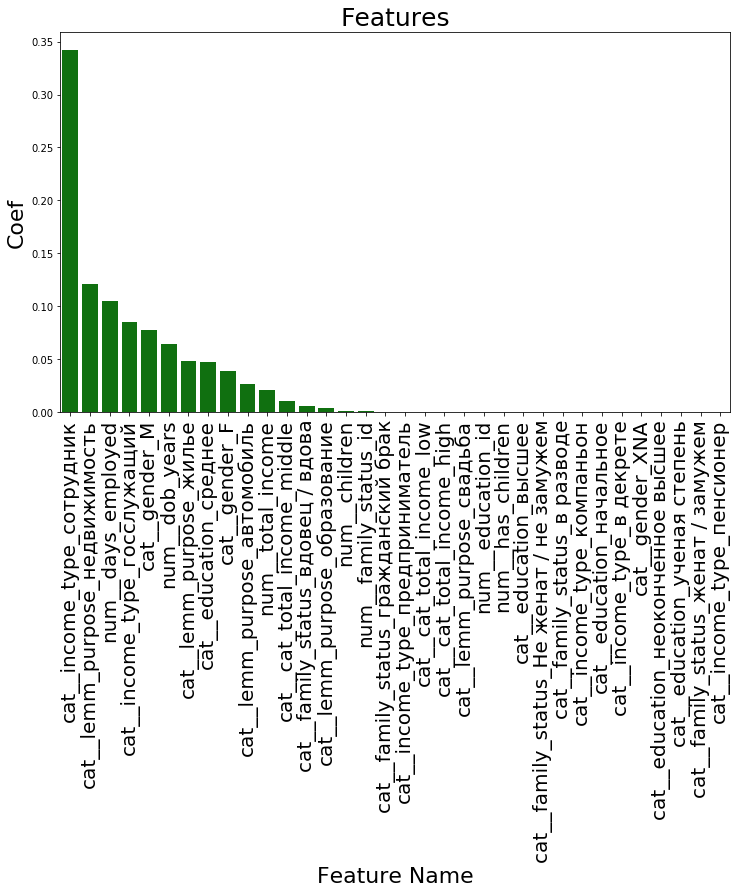

In [174]:
# vizualize feature importances
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df,
           palette=df["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

### Conclusion:


The most important features are linked with borrower's work, loan purpose and experience

### Model Testing

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'ROC curve')

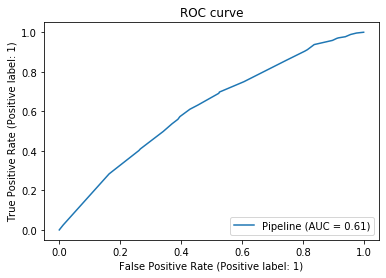

In [175]:
# plot ROC curve on train
metrics.plot_roc_curve(gsearch_dt.best_estimator_, X_train, y_train)
plt.title('ROC curve')

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'ROC curve')

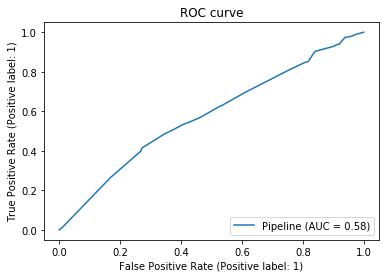

In [176]:
# plot ROC curve on test
metrics.plot_roc_curve(gsearch_dt.best_estimator_, X_test, y_test)
plt.title('ROC curve')

In [177]:
#run dummy test
dummy_clf = DummyClassifier(strategy="most_frequent")
dum = dummy_clf.fit(X, y)
roc_auc_score(y, dum.predict_proba(X)[:, 1])

0.5

### Conclusion:

Dummy test shows that our model is not just so much better than a constant one

## General Conclusion:

Summarizing all the above we find out that:
- The most solid borrowers have no children, are(or was) married, with high income. In other words people with life experience, permanent income and with no liability. Married couples with children who take loan to buy a car more often then others don't pay on time.
- We've built a simple machine learning model (DesicionTreeClassifire algorhitm) to predict payment failures. It shows f1 score = 0.76, precision = 0.86, recall = 0.70, accuracy = 0.7. The most important features are linked with borrower's work, loan purpose and experience. It means the bank can use it to evaluate borrowers payability to avoid losses.
